In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import sys

sys.path.append("..")

In [4]:
# Import the various experiments we need for the notebook
from sva.experiments import (
    Simple2d,
    PolicyPerformanceEvaluator,
    CampaignParameters,
)

# Import the seeding function for reproducibility
from sva.utils import seed_everything, set_mpl_defaults

/Users/mc/miniforge3/envs/py3.11-sva/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
set_mpl_defaults()

# A simple 2d example

The `Simple2d` example has a maximum at $x=(2, -4).$ Below, we initialize it, and plot the ground truth function as a 2d heatmap, along with the `n` randomly initialized data points and a red "x" for the location of the true maximum.

In [6]:
seed_everything(1234)
experiment = Simple2d()
experiment.initialize_data(n=5, protocol="random")

In [7]:
x = experiment.get_dense_coordinates(ppd=100)
y, _ = experiment(x)
extent = experiment.get_experimental_domain_mpl_extent()

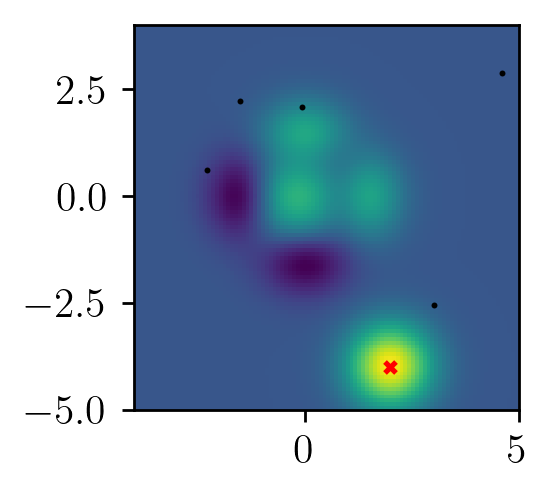

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))

X, Y = experiment.data.X, experiment.data.Y
ax.imshow(
    y.reshape(100, 100).T,
    extent=extent,
    interpolation="nearest",
    origin="lower",
)
ax.scatter(X[:, 0], X[:, 1], color="black", s=0.5)
ax.scatter(2, -4, s=10, color="red", marker="x")

plt.show()

We would expect that with relatively few initial samples, the policy performance evaluator will show that more exploratory acquisition functions are preferable.

In [9]:
seed_everything(1234)
experiment = Simple2d()
experiment.initialize_data(n=5, protocol="random")

In [10]:
parameter_list = CampaignParameters.from_standard_testing_array(use_EI=True, betas=[2.0, 20.0, 100.0])

In [11]:
policy_evaluator = PolicyPerformanceEvaluator(experiment, n_steps=5, n_dreams=3, checkpoint_dir=None)
policy_evaluator.run(parameter_list, n_jobs=12)

In [12]:
policy_results = policy_evaluator.process_results()

In [13]:
plot_kwargs = {
    "linewidth": 1.0,
    "marker": "s",
    "ms": 1.0,
    "capthick": 0.3,
    "capsize": 2.0,
    "elinewidth": 0.3,
}

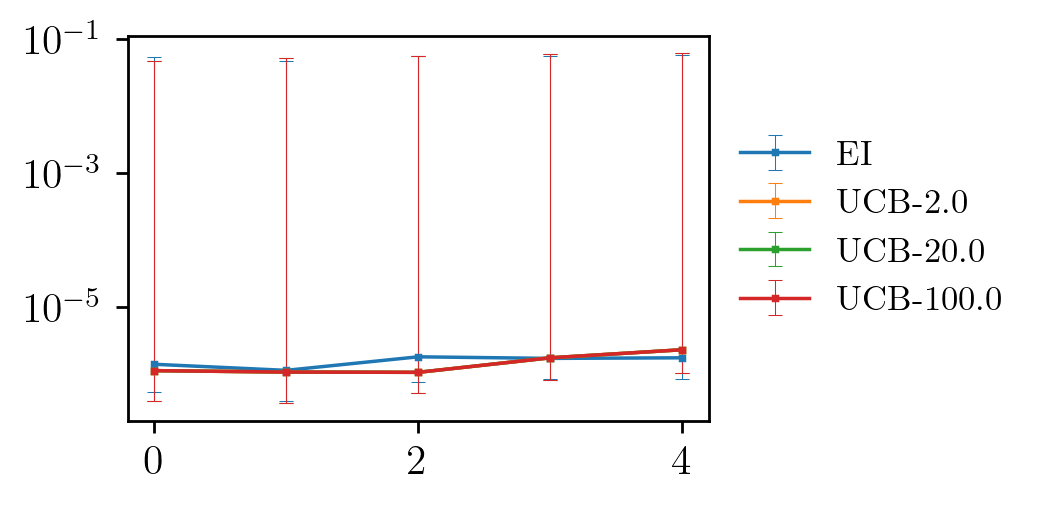

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2), sharex=True, sharey=True)

for ii, (key, value) in enumerate(policy_results.items()):
    res = value["results"]
    x = np.arange(res.shape[1])
    y = np.median(res, axis=0)
    percentiles = np.percentile(res, q=[25, 75], axis=0)
    ax.errorbar(x, y, yerr=percentiles, label=key, **plot_kwargs)
ax.legend(frameon=False, bbox_to_anchor=(1, 0.5), loc="center left")
ax.set_yscale("log")
plt.show()

It does appear to be the case that the overall opportunity cost is lowest using the most exploratory acquisition function (in the long term). If we start with far more initial points though this might not be the same.

In [15]:
seed_everything(1234)
experiment = Simple2d()
experiment.initialize_data(n=50, protocol="random")

In [16]:
policy_evaluator = PolicyPerformanceEvaluator(
    experiment, checkpoint_dir="checkpoints/simple2d/n50"
)
policy_evaluator.run(5, 50, parameter_list, n_jobs=12)

In [17]:
policy_results = policy_evaluator.process_results()

In [18]:
plot_kwargs = {
    "linewidth": 1.0,
    "marker": "s",
    "ms": 1.0,
    "capthick": 0.3,
    "capsize": 2.0,
    "elinewidth": 0.3,
}

-0.33693282904236926
-0.4130308033845888
-0.24147883241523133
-0.041513179438873726


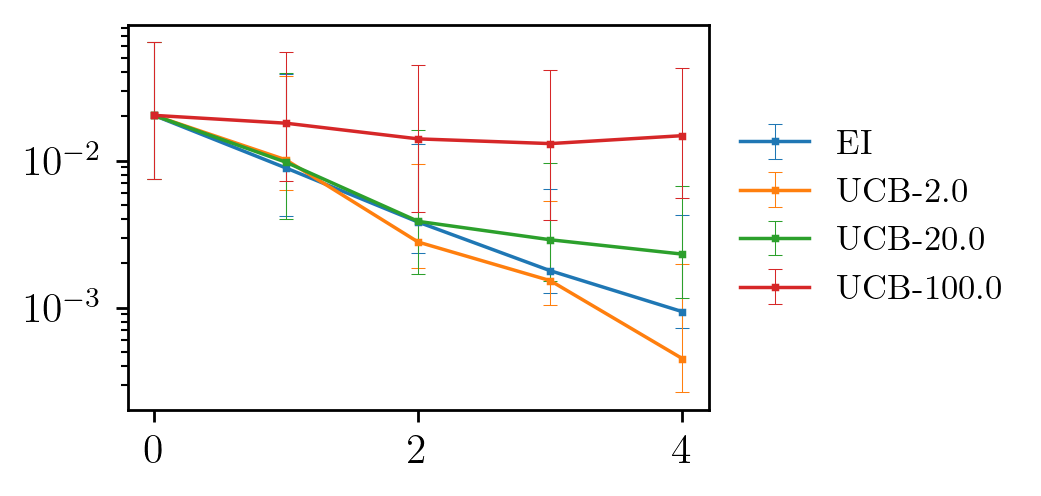

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2), sharex=True, sharey=True)

for ii, (key, value) in enumerate(policy_results.items()):
    res = value["results"]
    print(value["learning_rate"])
    x = np.arange(res.shape[1])
    y = np.median(res, axis=0)
    percentiles = np.percentile(res, q=[25, 75], axis=0)
    ax.errorbar(x, y, yerr=percentiles, label=key, **plot_kwargs)
ax.legend(frameon=False, bbox_to_anchor=(1, 0.5), loc="center left")
ax.set_yscale("log")
plt.show()

It does appear that the best policy here is the more exploitative UCB with $\beta=2.$ 

In [20]:
r = []
for key, value in policy_results.items():
    r.append((key, value["learning_rate"]))


In [22]:
r.sort(key=lambda x: x[1])

In [24]:
r[0]

('UCB-2.0', -0.4130308033845888)